# **Cyclists feature engineering**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import os

os.chdir(os.path.dirname(os.getcwd()))      # Move to parent directory


In [3]:
cyclists_df = pd.read_csv('dataset/cleaned_cyclists.csv')
races_df = pd.read_csv('dataset/cleaned_races.csv')

In [4]:
cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094 entries, 0 to 6093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _url         6094 non-null   object
 1   name         6094 non-null   object
 2   birth_year   6094 non-null   int64 
 3   nationality  6094 non-null   object
dtypes: int64(1), object(3)
memory usage: 190.6+ KB


## Numeric Features Engineering To Improve Clustering

This features will be used to try to improve clustering analysis

#### ```cyclist_experience``` column

Count how many stages the cyclist partecipate as an overall experience

In [5]:
# Group by cyclist and count the number of stages each cyclist participated in 
# Note: aassuming no duplicates in same stage
stages_participated = races_df.groupby('cyclist').size().reset_index(name='cyclist_experience')

# Rename 'cyclist' in stages_participated to avoid conflicts
stages_participated = stages_participated.rename(columns={'cyclist': 'cyclist_id'})

# Merge the stages_participated with cyclists_df to add the 'cyclist_experience' column
# Specify suffixes to avoid duplicate columns
cyclists_df = cyclists_df.merge(stages_participated, left_on='_url', right_on='cyclist_id', how='left')

# Drop the redundant 'cyclist_id' column from the merged DataFrame
cyclists_df = cyclists_df.drop(columns=['cyclist_id'])

# Replace NaN values in cyclist_experience with 0 (for cyclists with no participation records)
cyclists_df['cyclist_experience'] = cyclists_df['cyclist_experience'].fillna(0).astype(int)

# Check the output
print(cyclists_df[["_url", "cyclist_experience"]].head(3))

# Verify correctness of the computation (sum of cyclist_experience should match number of rows in races_df)
print("Total cyclist_experience:", cyclists_df['cyclist_experience'].sum())


          _url  cyclist_experience
0  bruno-surra                   1
1   gerard-rue                 222
2     jan-maas                  49
Total cyclist_experience: 589616


The sum is correct as we have as many entries as the rows in the dataset

In [6]:
print(f"Null values in cyclist_experience column: {int(cyclists_df['cyclist_experience'].isnull().sum())}")

Null values in cyclist_experience column: 0


In [7]:
cyclists_df['cyclist_experience'].describe()

count    6094.000000
mean       96.753528
std       140.776051
min         1.000000
25%         5.000000
50%        30.000000
75%       133.000000
max       959.000000
Name: cyclist_experience, dtype: float64

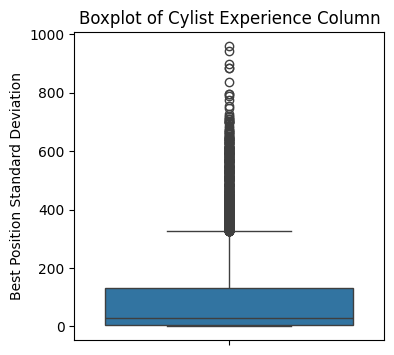

In [8]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='cyclist_experience', data=cyclists_df)
plt.title('Boxplot of Cylist Experience Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

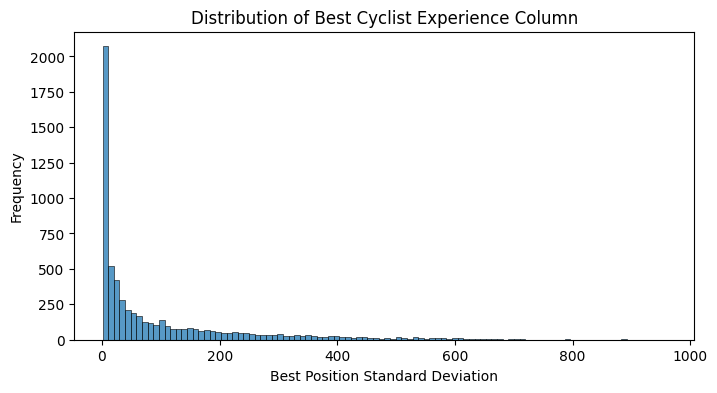

In [9]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_experience'], bins=100)
plt.title('Distribution of Best Cyclist Experience Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

In [10]:
threshold = 9

less_than_15_experience = (cyclists_df['cyclist_experience'] < threshold).sum()
print(f"Number of cyclists with less than {threshold} experience: {less_than_15_experience}")

Number of cyclists with less than 9 experience: 1877


Since many cyclists in this dataset have participated in very few stages, we have decided to exclude them. Our analysis focuses on **professional cyclists**, and we want to avoid the influence of non-professional ones (those with very few races) on our results. This exclusion will also improve the distribution of the following engineered features.

In [11]:
# Drop cyclists where experience is less than the threshold
cyclists_df = cyclists_df[cyclists_df['cyclist_experience'] >= threshold]

# Verify the result
print(f"Number of cyclists after dropping those with experience less than {threshold}: {len(cyclists_df)}")

Number of cyclists after dropping those with experience less than 9: 4217


Revamped analysis after the cleaning

In [12]:
cyclists_df['cyclist_experience'].describe()

count    4217.000000
mean      138.458146
std       151.626467
min         9.000000
25%        28.000000
50%        78.000000
75%       196.000000
max       959.000000
Name: cyclist_experience, dtype: float64

Replotting the boxplot of cyclists experience

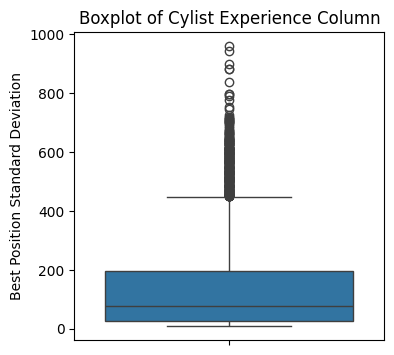

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='cyclist_experience', data=cyclists_df)
plt.title('Boxplot of Cylist Experience Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

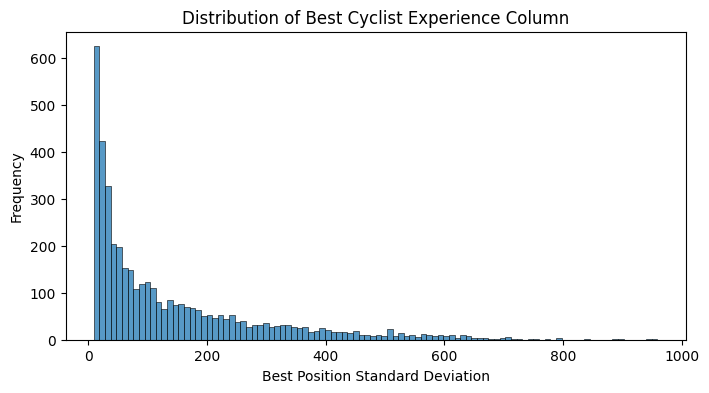

In [14]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_experience'], bins=100)
plt.title('Distribution of Best Cyclist Experience Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

#### ```cyclist_win``` column

Count how many stages won each cyclist

In [15]:
# Group by cyclist and count the number of times position is 0
stages_won = races_df[races_df['position'] == 0].groupby('cyclist').size().reset_index(name='position')

# Add cyclists who never had position 0 with counter set to 0
all_cyclists = pd.DataFrame(races_df['cyclist'].unique(), columns=['cyclist'])
stages_won_df = pd.merge(all_cyclists, stages_won, on='cyclist', how='left').fillna(0)

# Ensure position is an integer
stages_won_df['position'] = stages_won_df['position'].astype(int)
# Merge the stages_won_df with cyclists_df to add the 'cyclist_win' column
cyclists_df = cyclists_df.merge(stages_won_df, left_on='_url', right_on='cyclist', how='left')

# Rename the 'position' column to 'cyclist_win'
cyclists_df = cyclists_df.rename(columns={'position': 'cyclist_win'})

# Drop the redundant 'cyclist' column
cyclists_df = cyclists_df.drop(columns=['cyclist'])

print(cyclists_df[["_url", "cyclist_win"]].head(3))

#check correctness of the computation (sum(races won) = num. of races)
print("Total cyclist_wins:", cyclists_df['cyclist_win'].sum())


                   _url  cyclist_win
0            gerard-rue            3
1              jan-maas            0
2  nathan-van-hooydonck            0
Total cyclist_wins: 5232


Some useful analysis on win column like max, min, counting...

In [16]:
cyclists_df['cyclist_win'].describe()

count    4217.000000
mean        1.240692
std         4.313737
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        92.000000
Name: cyclist_win, dtype: float64

Plot distribution of stages won

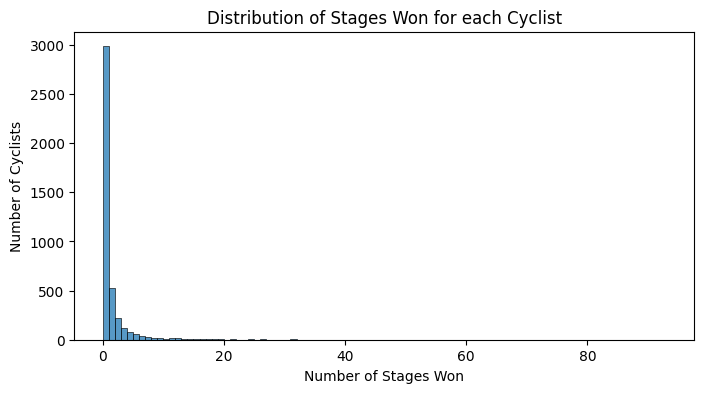

In [17]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_win'], bins=range(0, int(cyclists_df['cyclist_win'].max()) + 2), kde=False)
plt.title('Distribution of Stages Won for each Cyclist')
plt.xlabel('Number of Stages Won')
plt.ylabel('Number of Cyclists')
plt.show()

In [18]:
count_cyclist_win_gt_5 = cyclists_df[cyclists_df['cyclist_win'] > 3].shape[0]
print(f"Number of rows with cyclist_win > 3: {count_cyclist_win_gt_5}")

Number of rows with cyclist_win > 3: 364


As we can see from the plot and from the statistics very few cyclists win more then 3 stage, considering the overall

#### ```cyclist_win_ratio``` column

Compute the ratio betwen stages win and stages on which the cyclist partecipate. 

In [19]:
cyclists_df["cyclist_win_ratio"] = cyclists_df["cyclist_win"] / cyclists_df["cyclist_experience"]

Some useful analysis on win column like max, min, counting...

In [20]:
cyclists_df['cyclist_win_ratio'].describe()

count    4217.000000
mean        0.006907
std         0.020765
min         0.000000
25%         0.000000
50%         0.000000
75%         0.004049
max         0.288288
Name: cyclist_win_ratio, dtype: float64

In [21]:
cyclists_df["cyclist_win_ratio"].value_counts()

cyclist_win_ratio
0.000000    2984
0.022222       9
0.040000       7
0.100000       7
0.058824       7
            ... 
0.003636       1
0.016901       1
0.005525       1
0.028424       1
0.003322       1
Name: count, Length: 792, dtype: int64

Roughly 3/4 of the cyclistst never won a stage

#### ```avg_relative_position``` column

In [22]:
# Calculate the number of cyclists in each stage
stage_cyclist_counts = races_df['_url'].value_counts().reset_index()
stage_cyclist_counts.columns = ['_url', 'num_cyclists']

# Merge the stage_cyclist_counts with races_df to add the 'num_cyclists' column
races_df = races_df.merge(stage_cyclist_counts, on='_url', how='left')

# Compute the average position for each cyclist in each stage
races_df['avg_position'] = (races_df['position']+1) / races_df['num_cyclists']

In [23]:
# Merge races_df with cyclists_df to include cyclist information
merged_df = races_df.merge(cyclists_df, left_on='cyclist', right_on='_url', how='left')

# Compute the average finish position (normalized) for each cyclist
average_finish_position = merged_df.groupby('cyclist')['avg_position'].mean().reset_index()

# Rename the column for clarity
average_finish_position.rename(columns={'avg_position': 'avg_relative_position'}, inplace=True)

# Merge the result back to the cyclists_df
cyclists_df = cyclists_df.merge(average_finish_position, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'avg_relative_position']].head())

                   name  avg_relative_position
0           Gérard  Rué               0.456286
1             Jan  Maas               0.630686
2  Nathan Van Hooydonck               0.557360
3     José Félix  Parra               0.464642
4            Chad  Haga               0.589817


Some useful analysis on win column like max, min, counting...

In [24]:
cyclists_df['avg_relative_position'].describe()

count    4217.000000
mean        0.574334
std         0.133323
min         0.108822
25%         0.484408
50%         0.580553
75%         0.667220
max         0.946198
Name: avg_relative_position, dtype: float64

Plot distribution of stages won

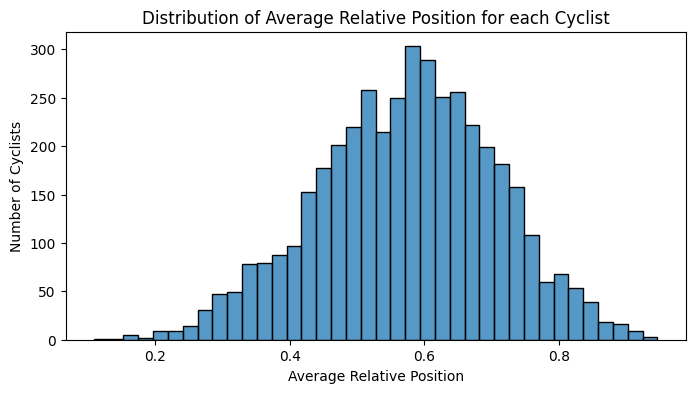

In [25]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['avg_relative_position'])
plt.title('Distribution of Average Relative Position for each Cyclist')
plt.xlabel('Average Relative Position')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```relative_position_std``` column

In [26]:
# Merge races_df with cyclists_df to include cyclist information
merged_df = races_df.merge(cyclists_df, left_on='cyclist', right_on='_url', how='left')

# Compute the average finish position (normalized) for each cyclist
average_finish_position = merged_df.groupby('cyclist')['avg_position'].std().reset_index()

# Rename the column for clarity
average_finish_position.rename(columns={'avg_position': 'relative_position_std'}, inplace=True)

# Merge the result back to the cyclists_df
cyclists_df = cyclists_df.merge(average_finish_position, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'relative_position_std']].head())

                   name  relative_position_std
0           Gérard  Rué               0.243635
1             Jan  Maas               0.205735
2  Nathan Van Hooydonck               0.219011
3     José Félix  Parra               0.238795
4            Chad  Haga               0.238517


Some useful analysis on win column like max, min, counting...

In [27]:
cyclists_df['relative_position_std'].describe()

count    4217.000000
mean        0.250549
std         0.050463
min         0.044274
25%         0.221124
50%         0.250204
75%         0.279957
max         0.419460
Name: relative_position_std, dtype: float64

Plot distribution of stages won

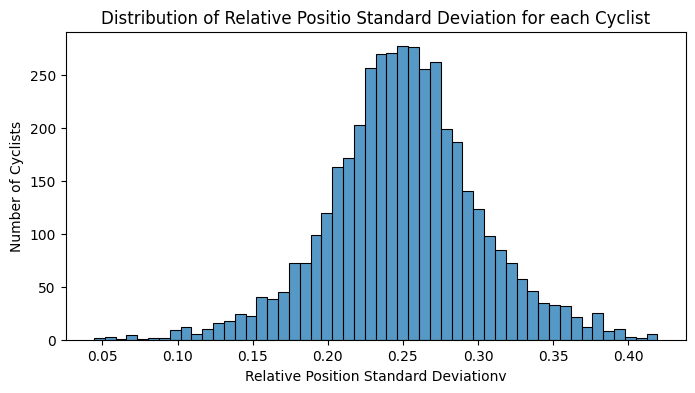

In [28]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['relative_position_std'])
plt.title('Distribution of Relative Positio Standard Deviation for each Cyclist')
plt.xlabel('Relative Position Standard Deviationv')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```mean_last_10_positions``` column

A temporary column is added that is used to calculate the number of cilcists present in each race ('cyclist_number')

In [29]:
# Count the number of occurrences of each _url
url_counts = races_df['_url'].value_counts().reset_index()
url_counts.columns = ['_url', 'cyclist_number']

# Merge the counts back to the original dataframe
races_df_temp = races_df.merge(url_counts, on='_url', how='left')

In [30]:
# Ordinare il DataFrame 
races_df_temp = races_df_temp.sort_values(by=['cyclist', 'position'])

# Funzione per calcolare la media delle ultime 10 posizioni
def mean_last_10_positions(group):
    return (group['position'] / group['cyclist_number']).tail(10).mean()

# Applicare la funzione a ogni gruppo di ciclisti
mean_last_10_positions_df = races_df_temp.groupby('cyclist').apply(mean_last_10_positions).reset_index(name='mean_last_10_positions')


# Unire il risultato con il DataFrame dei ciclisti
cyclists_df = cyclists_df.merge(mean_last_10_positions_df, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Visualizzare le prime righe per verificare
print(cyclists_df[['name', 'mean_last_10_positions']].head())


                   name  mean_last_10_positions
0           Gérard  Rué                0.808564
1             Jan  Maas                0.857294
2  Nathan Van Hooydonck                0.897087
3     José Félix  Parra                0.790558
4            Chad  Haga                0.951626


C:\Users\franc\AppData\Local\Temp\ipykernel_12304\1069849528.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_last_10_positions_df = races_df_temp.groupby('cyclist').apply(mean_last_10_positions).reset_index(name='mean_last_10_positions')


#### ```min_relative_position``` column

In [31]:
# Compute the average finish position (normalized) for each cyclist
min_finish_position = merged_df.groupby('cyclist')['avg_position'].min().reset_index()

# Rename the column for clarity
min_finish_position.rename(columns={'avg_position': 'min_relative_position'}, inplace=True)

# Merge the result back to the cyclists_df
cyclists_df = cyclists_df.merge(min_finish_position, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'min_relative_position']].head())

                   name  min_relative_position
0           Gérard  Rué               0.021978
1             Jan  Maas               0.194690
2  Nathan Van Hooydonck               0.052632
3     José Félix  Parra               0.153374
4            Chad  Haga               0.007042


Some useful analysis on win column like max, min, counting...

In [32]:
cyclists_df['min_relative_position'].describe()

count    4217.000000
mean        0.094970
std         0.128849
min         0.004762
25%         0.011429
50%         0.039735
75%         0.125000
max         0.859873
Name: min_relative_position, dtype: float64

Plot distribution of stages won

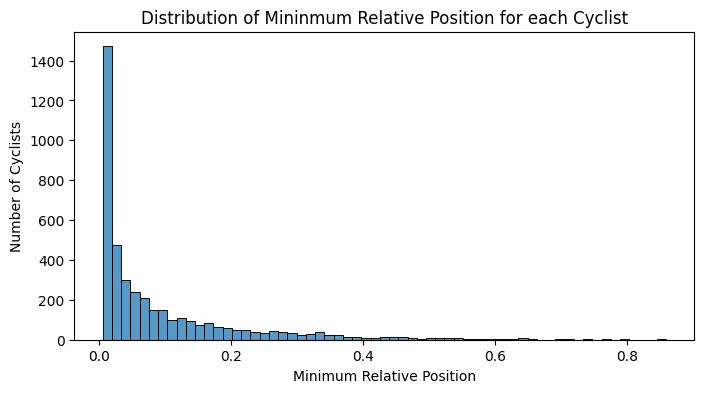

In [33]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['min_relative_position'])
plt.title('Distribution of Mininmum Relative Position for each Cyclist')
plt.xlabel('Minimum Relative Position')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```avg_position_vs_startlist``` column

Compute the ratio between position and startlist quality and average over all stages runned by the cyclists. This measure underlines the performance of the cyclist taking into account also the overall quality of the cyclists at the start

In [34]:
# Compute the position scaled by the startlist
races_df['performance_vs_startlist'] = (races_df['position'] + 1) / races_df['startlist_quality']

In [35]:
# Merge races_df with cyclists_df to include cyclist information
merged_df = races_df.merge(cyclists_df, left_on='cyclist', right_on='_url', how='left')

# Compute the average performance vs startlist for each cyclist
average_finish_position = merged_df.groupby('cyclist')['performance_vs_startlist'].mean().reset_index()

# Rename the column for clarity
average_finish_position.rename(columns={'performance_vs_startlist': 'avg_performance_vs_startlist'}, inplace=True)

# Merge the result back to the cyclists_df
cyclists_df = cyclists_df.merge(average_finish_position, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'avg_performance_vs_startlist']].head())

                   name  avg_performance_vs_startlist
0           Gérard  Rué                      0.040912
1             Jan  Maas                      0.120045
2  Nathan Van Hooydonck                      0.085740
3     José Félix  Parra                      0.109783
4            Chad  Haga                      0.102977


Some useful analysis on win column like max, min, counting...

In [36]:
cyclists_df['avg_performance_vs_startlist'].describe()

count    4217.000000
mean        0.084120
std         0.034343
min         0.006353
25%         0.058596
50%         0.081758
75%         0.106334
max         0.342399
Name: avg_performance_vs_startlist, dtype: float64

Boxplot distribution Average Performance vs Startlist

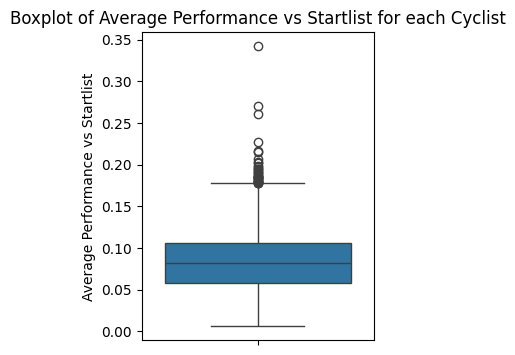

In [37]:
# Plot the boxplot of avg_performance_vs_startlist
plt.figure(figsize=(3, 4))
sns.boxplot(y='avg_performance_vs_startlist', data=cyclists_df)
plt.title('Boxplot of Average Performance vs Startlist for each Cyclist')
plt.ylabel('Average Performance vs Startlist')
plt.show()

Plot distribution Average Performance vs Startlist

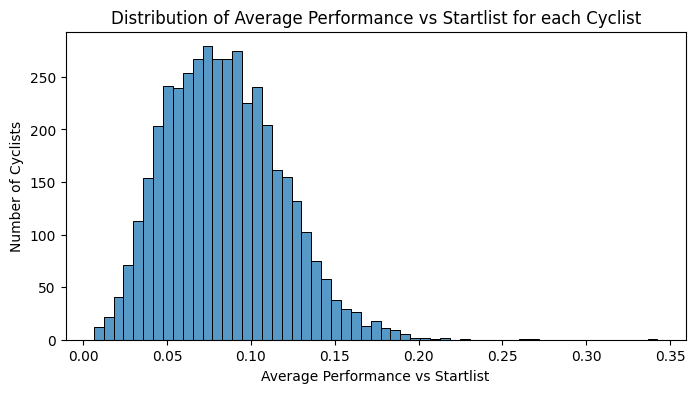

In [38]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['avg_performance_vs_startlist'])
plt.title('Distribution of Average Performance vs Startlist for each Cyclist')
plt.xlabel('Average Performance vs Startlist')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```performance_entropy``` column

Performance variability metrics capture how consistent or unpredictable a cyclist's performance is across different races and stages. These metrics provide insight into whether a cyclist tends to perform steadily or fluctuates significantly

In [39]:
# Group by cyclist and sum the avg_position
# note: avg_position = position/num_cyclists for each stage

cyclist_avg_position_sum = races_df.groupby('cyclist')['avg_position'].sum().reset_index()

# Rename the column for clarity
cyclist_avg_position_sum.rename(columns={'avg_position': 'sum_avg_position'}, inplace=True)

# Merge the cyclist_avg_position_sum with races_df to add the 'sum_avg_position' column
races_df = races_df.merge(cyclist_avg_position_sum, on='cyclist', how='left')

races_df["performance_entropy"] = races_df["avg_position"] / races_df["sum_avg_position"]

In [40]:
import numpy as np
import pandas as pd

# Calculate p_i (proportion of avg_position to sum_avg_position for each cyclist)
races_df['p_i'] = races_df['avg_position'] / races_df['sum_avg_position']

# Compute the entropy component for each stage
races_df['entropy_component'] = -races_df['p_i'] * np.log(races_df['p_i'])

# Aggregate and sum by cyclist to calculate total entropy
cyclist_entropy = races_df.groupby('cyclist')['entropy_component'].sum().reset_index()

# Rename the column
cyclist_entropy = cyclist_entropy.rename(columns={'entropy_component': 'performance_entropy'})

# Merge the cyclist_entropy with cyclists_df to add the 'performance_entropy' column
cyclists_df = cyclists_df.merge(cyclist_entropy, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'performance_entropy']].head())

                   name  performance_entropy
0           Gérard  Rué             5.246679
1             Jan  Maas             3.835542
2  Nathan Van Hooydonck             4.996583
3     José Félix  Parra             3.745187
4            Chad  Haga             5.853528


In [41]:
cyclists_df['performance_entropy'].describe()

count    4217.000000
mean        4.176811
std         1.143333
min         1.880880
25%         3.212280
50%         4.223256
75%         5.131582
max         6.763185
Name: performance_entropy, dtype: float64

Boxplot distribution Average Performance vs Startlist

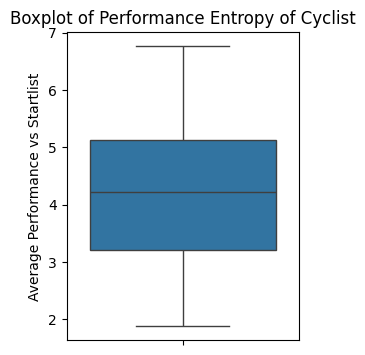

In [42]:
# Plot the boxplot of avg_performance_vs_startlist
plt.figure(figsize=(3, 4))
sns.boxplot(y='performance_entropy', data=cyclists_df)
plt.title('Boxplot of Performance Entropy of Cyclist')
plt.ylabel('Average Performance vs Startlist')
plt.show()

Plot distribution Average Performance vs Startlist

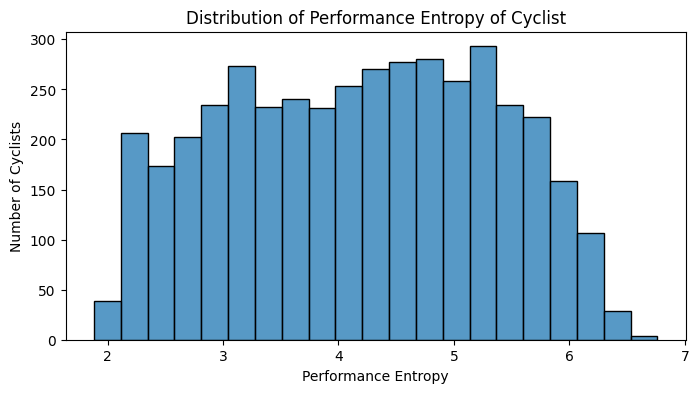

In [43]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['performance_entropy'])
plt.title('Distribution of Performance Entropy of Cyclist')
plt.xlabel('Performance Entropy')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```weighted_podiums``` column

cyclist's carreer level is calculated by considering all the stages partecipated. 
The carreer level of the cyclis is computed as follows: 
$$
V = \frac{1}{T} \sum_{i=1}^{4} \left( N_i \cdot W_i \cdot P_i \right)
$$

In [44]:
# Sort the `races_df` DataFrame by the '_url' and 'start_date' columns 
races_df = races_df.sort_values(by=['_url', 'start_date'], kind='mergesort')  

**position weigth**

In [45]:
from utils import compute_cyclist_performance

WEIGHTS = {
    '1_points': 1.0,     # Weight for wins
    '2_points': 0.90,    # Weight for second places
    '3_points': 0.80,    # Weight for third places
}

cyclist_performance = compute_cyclist_performance(races_df, WEIGHTS)

In [46]:
# Add a carreer_level column to the cyclists_df
cyclists_df['weighted_podiums'] = 0.0

for cyclist, races in cyclist_performance.items():
    total_races = cyclist_performance[cyclist]['total_races']
    placement_sum = 0
    
    # Iterate over the keys in the WEIGHTS dictionary
    for position in WEIGHTS:
        # If the key is present in the cyclist's dictionary
        # e.g. cyclist has array associated with '1_points'
        if position in cyclist_performance[cyclist]:
            # For all points related to the times the cyclist achieved the "position" (e.g., 1_points)
            for points in cyclist_performance[cyclist][position]:
                # Sum the weighted points
                placement_sum += WEIGHTS[position] * points

    # Normalize the level by dividing the total races
    normalized_level = placement_sum / total_races
    
    # Update the 'carreer_level' in the cyclist_df
    cyclists_df.loc[cyclists_df['_url'] == cyclist, 'weighted_podiums'] = normalized_level

Revamped analysis

In [47]:
cyclists_df['weighted_podiums'].describe()

count    4217.000000
mean        1.735535
std         4.808550
min         0.000000
25%         0.000000
50%         0.000000
75%         1.448000
max        74.903846
Name: weighted_podiums, dtype: float64

In [48]:
print(cyclists_df[cyclists_df['weighted_podiums'] < 5][['_url', 'weighted_podiums']])

                        _url  weighted_podiums
0                 gerard-rue          3.509009
1                   jan-maas          0.000000
2       nathan-van-hooydonck          0.000000
3           jose-felix-parra          0.000000
4                  chad-haga          0.208333
...                      ...               ...
4212  francisco-jose-pacheco          0.000000
4213          inigo-elosegui          0.000000
4214          paolo-alberati          0.000000
4215       jackson-rodriguez          0.637168
4216            ward-vanhoof          0.000000

[3830 rows x 2 columns]


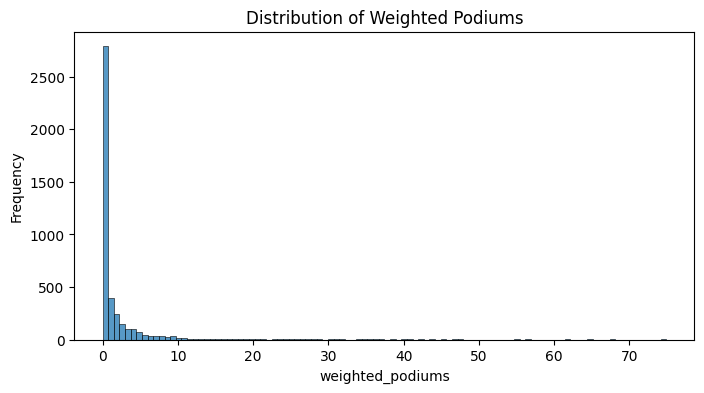

In [49]:
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['weighted_podiums'], bins=100)
plt.title('Distribution of Weighted Podiums')
plt.xlabel('weighted_podiums')
plt.ylabel('Frequency')
plt.show()

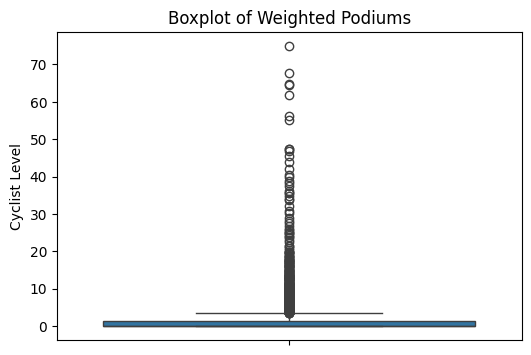

In [50]:
plt.figure(figsize=(6, 4))
sns.boxplot(y='weighted_podiums', data=cyclists_df)
plt.title('Boxplot of Weighted Podiums')
plt.ylabel('Cyclist Level')
plt.show()

#### ```career_level``` column 

In [51]:
# Sort the `races_df` DataFrame by the '_url' and 'start_date' columns 
races_df = races_df.sort_values(by=['_url', 'start_date'], kind='mergesort')  

In [52]:
import math

WEIGHTS = {f'{i}_points': math.floor((1 - (i - 1) * 0.02) * 100) / 100 for i in range(1, 51)}
print(WEIGHTS)

{'1_points': 1.0, '2_points': 0.98, '3_points': 0.96, '4_points': 0.94, '5_points': 0.92, '6_points': 0.9, '7_points': 0.88, '8_points': 0.86, '9_points': 0.84, '10_points': 0.82, '11_points': 0.8, '12_points': 0.78, '13_points': 0.76, '14_points': 0.74, '15_points': 0.72, '16_points': 0.7, '17_points': 0.68, '18_points': 0.65, '19_points': 0.64, '20_points': 0.62, '21_points': 0.6, '22_points': 0.58, '23_points': 0.56, '24_points': 0.54, '25_points': 0.52, '26_points': 0.5, '27_points': 0.48, '28_points': 0.46, '29_points': 0.43, '30_points': 0.42, '31_points': 0.4, '32_points': 0.38, '33_points': 0.36, '34_points': 0.34, '35_points': 0.31, '36_points': 0.29, '37_points': 0.28, '38_points': 0.26, '39_points': 0.24, '40_points': 0.21, '41_points': 0.19, '42_points': 0.17, '43_points': 0.16, '44_points': 0.14, '45_points': 0.12, '46_points': 0.09, '47_points': 0.07, '48_points': 0.05, '49_points': 0.04, '50_points': 0.02}


In [53]:
# Add a carreer_level column to the cyclists_df
cyclists_df['career_level'] = 0.0

for cyclist, races in cyclist_performance.items():
    total_races = cyclist_performance[cyclist]['total_races']
    placement_sum = 0
    
    # Iterate over the keys in the WEIGHTS dictionary
    for position in WEIGHTS:
        # If the key is present in the cyclist's dictionary
        # e.g. cyclist has array associated with '1_points'
        if position in cyclist_performance[cyclist]:
            # For all points related to the times the cyclist achieved the "position" (e.g., 1_points)
            for points in cyclist_performance[cyclist][position]:
                # Sum the weighted points
                placement_sum += WEIGHTS[position] * points

    # Normalize the level by dividing the total races
    normalized_level = placement_sum
    
    # Update the 'carreer_level' in the cyclist_df
    cyclists_df.loc[cyclists_df['_url'] == cyclist, 'career_level'] = normalized_level

##### Revamped analysis

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Reshape and transform the column
cyclists_df['career_level'] = scaler.fit_transform(cyclists_df[['career_level']])

# Check the normalized values
cyclists_df['career_level'].describe()

count    4.217000e+03
mean    -1.019394e-16
std      1.000119e+00
min     -6.009643e-01
25%     -5.542799e-01
50%     -4.029864e-01
75%      1.103748e-01
max      1.240025e+01
Name: career_level, dtype: float64

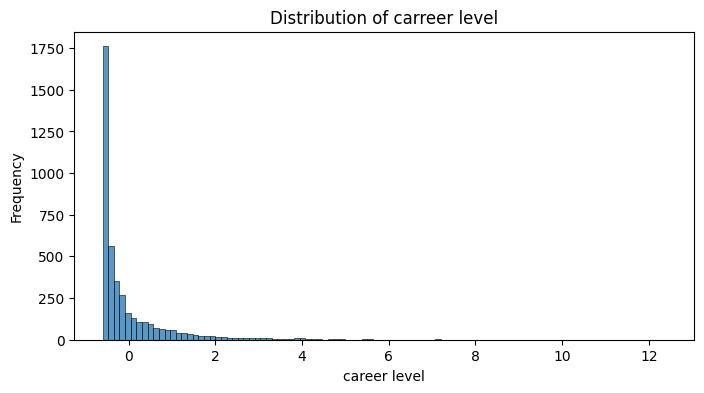

In [55]:
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['career_level'], bins=100)
plt.title('Distribution of carreer level')
plt.xlabel('career level')
plt.ylabel('Frequency')
plt.show()

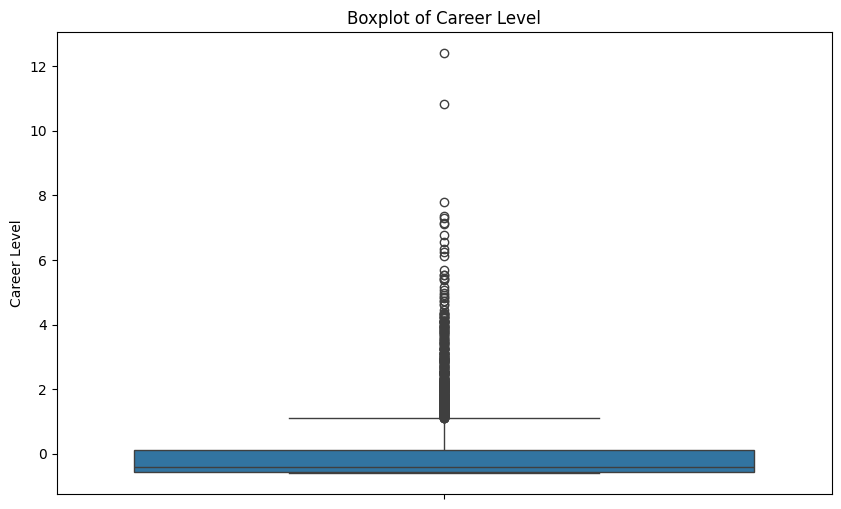

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='career_level', data=cyclists_df)
plt.title('Boxplot of Career Level')
plt.ylabel('Career Level')
plt.show()

#### ```avg_position``` column

In [57]:
# Group by cyclist and compute the average position
average_position = races_df.groupby('cyclist')['position'].mean().reset_index()

# Rename the column for clarity
average_position.rename(columns={'position': 'avg_position'}, inplace=True)

# Merge the result back to the cyclists_df
cyclists_df = cyclists_df.merge(average_position, left_on='_url', right_on='cyclist', how='left').drop(columns=['cyclist'])

# Display the first few rows to verify
print(cyclists_df[['name', 'avg_position']].head())

                   name  avg_position
0           Gérard  Rué     63.545045
1             Jan  Maas     87.693878
2  Nathan Van Hooydonck     83.242236
3     José Félix  Parra     68.000000
4            Chad  Haga     93.127604


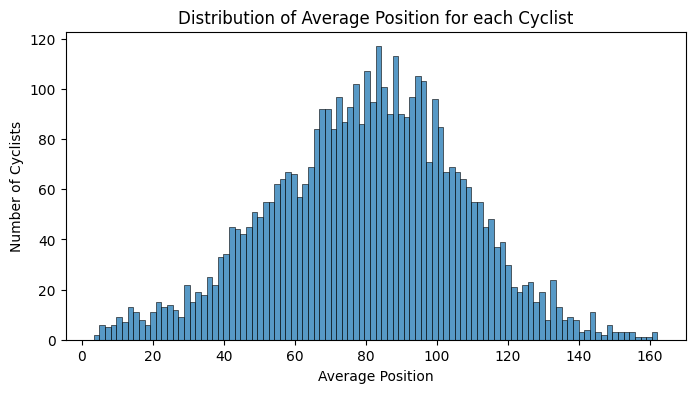

In [58]:
# Plot the distribution of avg_position
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['avg_position'], bins=100)
plt.title('Distribution of Average Position for each Cyclist')
plt.xlabel('Average Position')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```best_position``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [59]:
best_finish_position = races_df.groupby('cyclist')['position'].min().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

In [60]:
print(f"Null values in best_position column: {int(cyclists_df['best_position'].isnull().sum())}")

Null values in best_position column: 0


In [61]:
cyclists_df['best_position'].describe()

count    4217.000000
mean       10.367323
std        17.434943
min         0.000000
25%         0.000000
50%         3.000000
75%        12.000000
max       130.000000
Name: best_position, dtype: float64

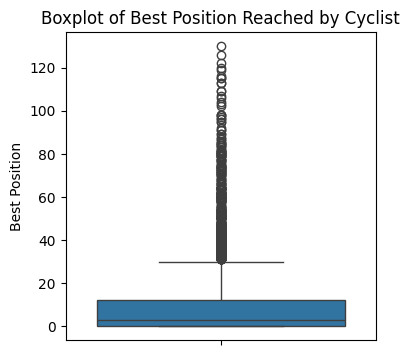

In [62]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position', data=cyclists_df)
plt.title('Boxplot of Best Position Reached by Cyclist')
plt.ylabel('Best Position')
plt.show()

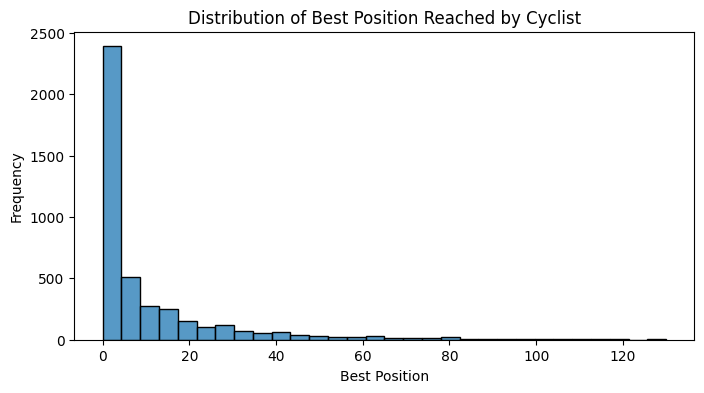

In [63]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position'], bins=30)
plt.title('Distribution of Best Position Reached by Cyclist')
plt.xlabel('Best Position')
plt.ylabel('Frequency')
plt.show()

Checking the number of races in which cyclists who have never finished above 100th position have participated, with the assumption that these are cyclists with participation limited to a few stages or a single stage.

In [64]:
# Filter cyclists who have never finished above 150th position
cyclists_never_above_150 = cyclists_df[cyclists_df['best_position'] > 100]['_url']

# Filter races_df to include only these cyclists
races_never_above_150 = races_df[races_df['cyclist'].isin(cyclists_never_above_150)]

# Count the number of stages each of these cyclists has participated in
# NOTE: at this point no cyclist has a duplicated entry in the same stage
races_count_never_above_150 = races_never_above_150['cyclist'].value_counts()

# Merge the counts with the best positions
races_count_with_best_position = races_count_never_above_150.to_frame().merge(
    cyclists_df, left_index=True, right_on='_url',
).rename(columns={'_url': 'cyclist name', 'count': 'Number of Stages', 'best_position': 'Best Position'})

# Display the result
print(races_count_with_best_position[['cyclist name', 'Number of Stages', 'Best Position']])

                    cyclist name  Number of Stages  Best Position
608                sho-hatsuyama                36            115
4062             giuliano-biatta                21            102
3164       hector-manuel-castano                16            103
1967             andoni-lafuente                15            120
3876            sebastian-lander                12            130
2885           benedito-ferreira                11            106
839                david-vitoria                11            113
2005         patrick-schoovaerts                11            116
390                  ivan-santos                11            107
4087          bernhard-rassinger                10            126
848           ricardo-felgueiras                10            113
1520                  dylan-page                 9            104
2085       joao-da-silva-correia                 9            119
1233  tomas-aurelio-gil-martinez                 9            115
281       

As expected, these cyclists will take part in very few stages so they probably are not so strong

#### ```best_position_std``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [65]:
best_finish_position = races_df.groupby('cyclist')['position'].std().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position_std'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

In [66]:
print(f"Null values in best_position_std column: {int(cyclists_df['best_position_std'].isnull().sum())}")

Null values in best_position_std column: 0


When the cyclist attends only one stage, the standard deviation is zero, so we replace it with 0 which should be intended as no standard deviation.

In [67]:
cyclists_df.fillna({'best_position_std':0}, inplace=True)

# Verify if the operation was successful
print(f"Null values in best_position_std column: {int(cyclists_df['best_position_std'].isnull().sum())}")

Null values in best_position_std column: 0


In [68]:
cyclists_df['best_position_std'].describe()

count    4217.000000
mean       40.361466
std        10.501398
min         4.004405
25%        34.604679
50%        40.677654
75%        46.706315
max        84.118099
Name: best_position_std, dtype: float64

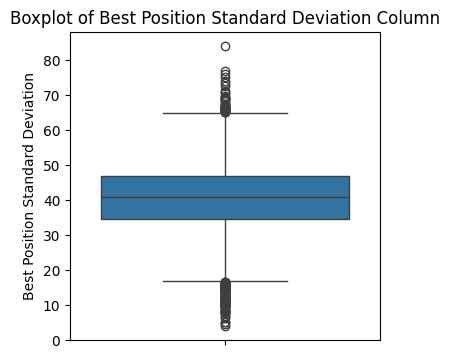

In [69]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position_std', data=cyclists_df)
plt.title('Boxplot of Best Position Standard Deviation Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

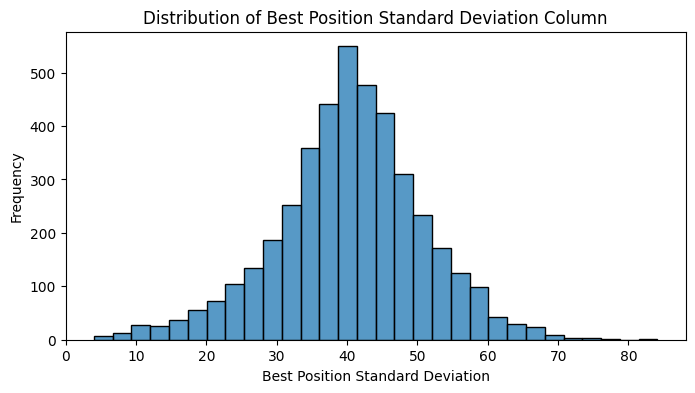

In [70]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position_std'], bins=30)
plt.title('Distribution of Best Position Standard Deviation Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

---

## Categorical Feature Engineering 

This features will be used to try to explain the clustering results

### ```top_cyclists``` column

Divide cyclists in top categories based on carreer level columns. This feature is the most promising feature to explain experience-based clustering

In [71]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_df.sort_values(by='career_level', ascending=False)

# Define the bins and labels
bins = [0, 21, 51, 151, 501, 751, 1001, 1301, 1701, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 750', 'Top 1000', 'Top 1300', 'Top 1700', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_cyclists'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

# Add the 'top_cyclists' column to the original cyclists_df
cyclists_df = cyclists_df.merge(sorted_cyclists_df[['_url', 'top_cyclists']], on='_url', how='left')

In [72]:
cyclists_df.value_counts("top_cyclists")

top_cyclists
Rest        716
Top 2500    500
Top 3000    500
Top 3500    500
Top 1700    400
Top 500     350
Top 1300    300
Top 2000    300
Top 750     250
Top 1000    250
Top 150     100
Top 50       30
Top 20       20
Name: count, dtype: int64

In [73]:
#sorted_cyclists_df[["name", "career_level","top_cyclists"]].head(50)
antonio_nibali_row = sorted_cyclists_df[sorted_cyclists_df["_url"] == "vincenzo-nibali"]
antonio_nibali_row


_url              name  birth_year nationality  \
2613  vincenzo-nibali  Vincenzo  Nibali        1984       Italy   

      cyclist_experience  cyclist_win  cyclist_win_ratio  \
2613                 796           16           0.020101   

      avg_relative_position  relative_position_std  mean_last_10_positions  \
2613               0.209118               0.178153                0.781074   

      ...  avg_performance_vs_startlist  performance_entropy  \
2613  ...                      0.030787             6.350886   

      weighted_podiums  career_level  avg_position        cyclist_x  \
2613           5.81407      7.788545      31.30402  vincenzo-nibali   

     best_position        cyclist_y best_position_std  top_cyclists  
2613             0  vincenzo-nibali         26.828466        Top 20  

[1 rows x 21 columns]

### ```top_experience``` column

This column will be used to try to characterize clustering results

In [74]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_df.sort_values(by='cyclist_experience', ascending=False)

# Define the bins and labels
bins = [0, 21, 51, 151, 501, 751, 1001, 1301, 1701, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 750', 'Top 1000', 'Top 1300', 'Top 1700', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_experience'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

# Add the 'top_cyclists' column to the original cyclists_df
cyclists_df = cyclists_df.merge(sorted_cyclists_df[['_url', 'top_experience']], on='_url', how='left')

### ```continent``` column

Continent column is created to reduce number of classes of nationality. If clusters capture nationality informations this column could be useful

In [75]:
# Function to convert country name to continent
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# Apply the function to create a new column 'continent'
cyclists_df['continent'] = cyclists_df['nationality'].apply(country_to_continent)

# Display the first few rows to verify
print(cyclists_df[['nationality', 'continent']].head(10))

     nationality      continent
0         France         Europe
1    Netherlands         Europe
2        Belgium         Europe
3          Spain         Europe
4  United States  North America
5    Netherlands         Europe
6  Great Britain         Europe
7          Spain         Europe
8          Italy         Europe
9         France         Europe


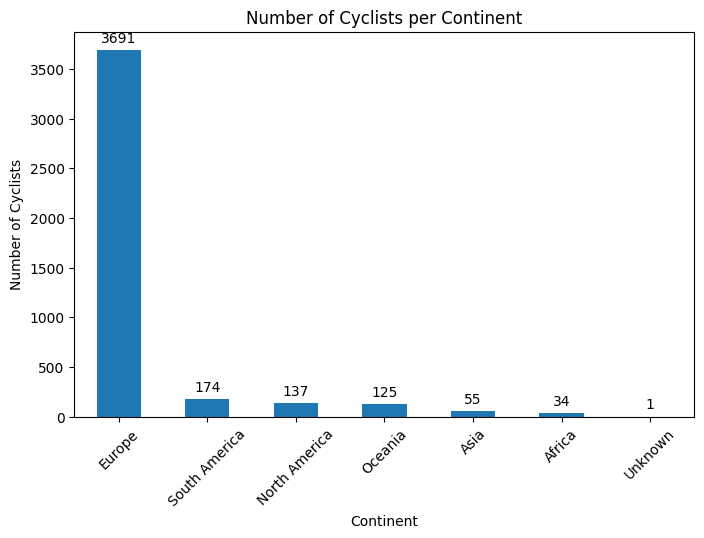

In [76]:
# Count the number of cyclists per continent
continent_counts = cyclists_df['continent'].value_counts()

# Plot the number of cyclists per continent as a histogram
plt.figure(figsize=(8, 5))
ax = continent_counts.plot(kind='bar')
plt.title('Number of Cyclists per Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=45)

# Add the count above each bin
for i, count in enumerate(continent_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom')

plt.show()

The problem with this column is that the most cyclists belong to European continent, so its very unbalanced.

Given that majority of cyclists are european let's deep into european cyclist analysis

In [77]:
# Filter cyclists by European continent
european_df = cyclists_df[cyclists_df['continent'] == 'Europe'].drop(columns=['continent'])

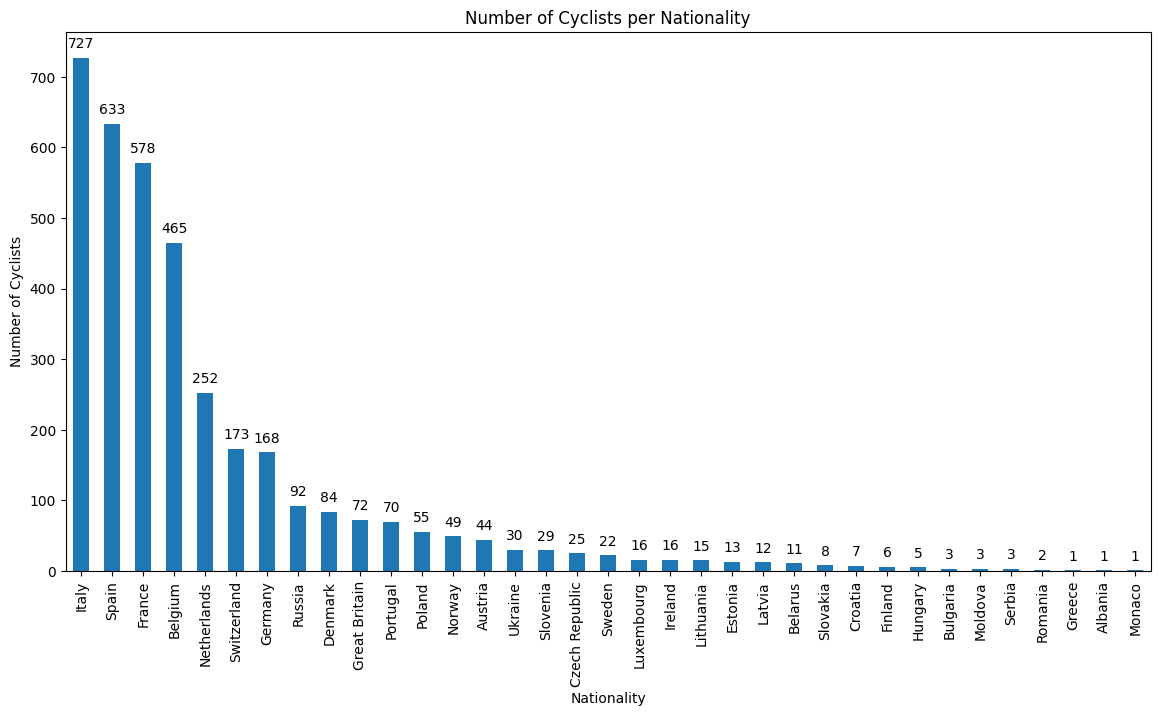

In [78]:
# Count the number of cyclists per nationality
nationality_counts = european_df['nationality'].value_counts()

# Plot the number of cyclists per nationality as a histogram
plt.figure(figsize=(14, 7))
ax = nationality_counts.plot(kind='bar')
plt.title('Number of Cyclists per Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=90)

# Add the count above each bin
for i, count in enumerate(nationality_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

## Remaining Columns

In [79]:
cyclists_df.drop(columns=['cyclist_x', 'cyclist_y' ], inplace=True)
cyclists_df.columns.to_list()

['_url',
 'name',
 'birth_year',
 'nationality',
 'cyclist_experience',
 'cyclist_win',
 'cyclist_win_ratio',
 'avg_relative_position',
 'relative_position_std',
 'mean_last_10_positions',
 'min_relative_position',
 'avg_performance_vs_startlist',
 'performance_entropy',
 'weighted_podiums',
 'career_level',
 'avg_position',
 'best_position',
 'best_position_std',
 'top_cyclists',
 'top_experience',
 'continent']

## Scatter Plots

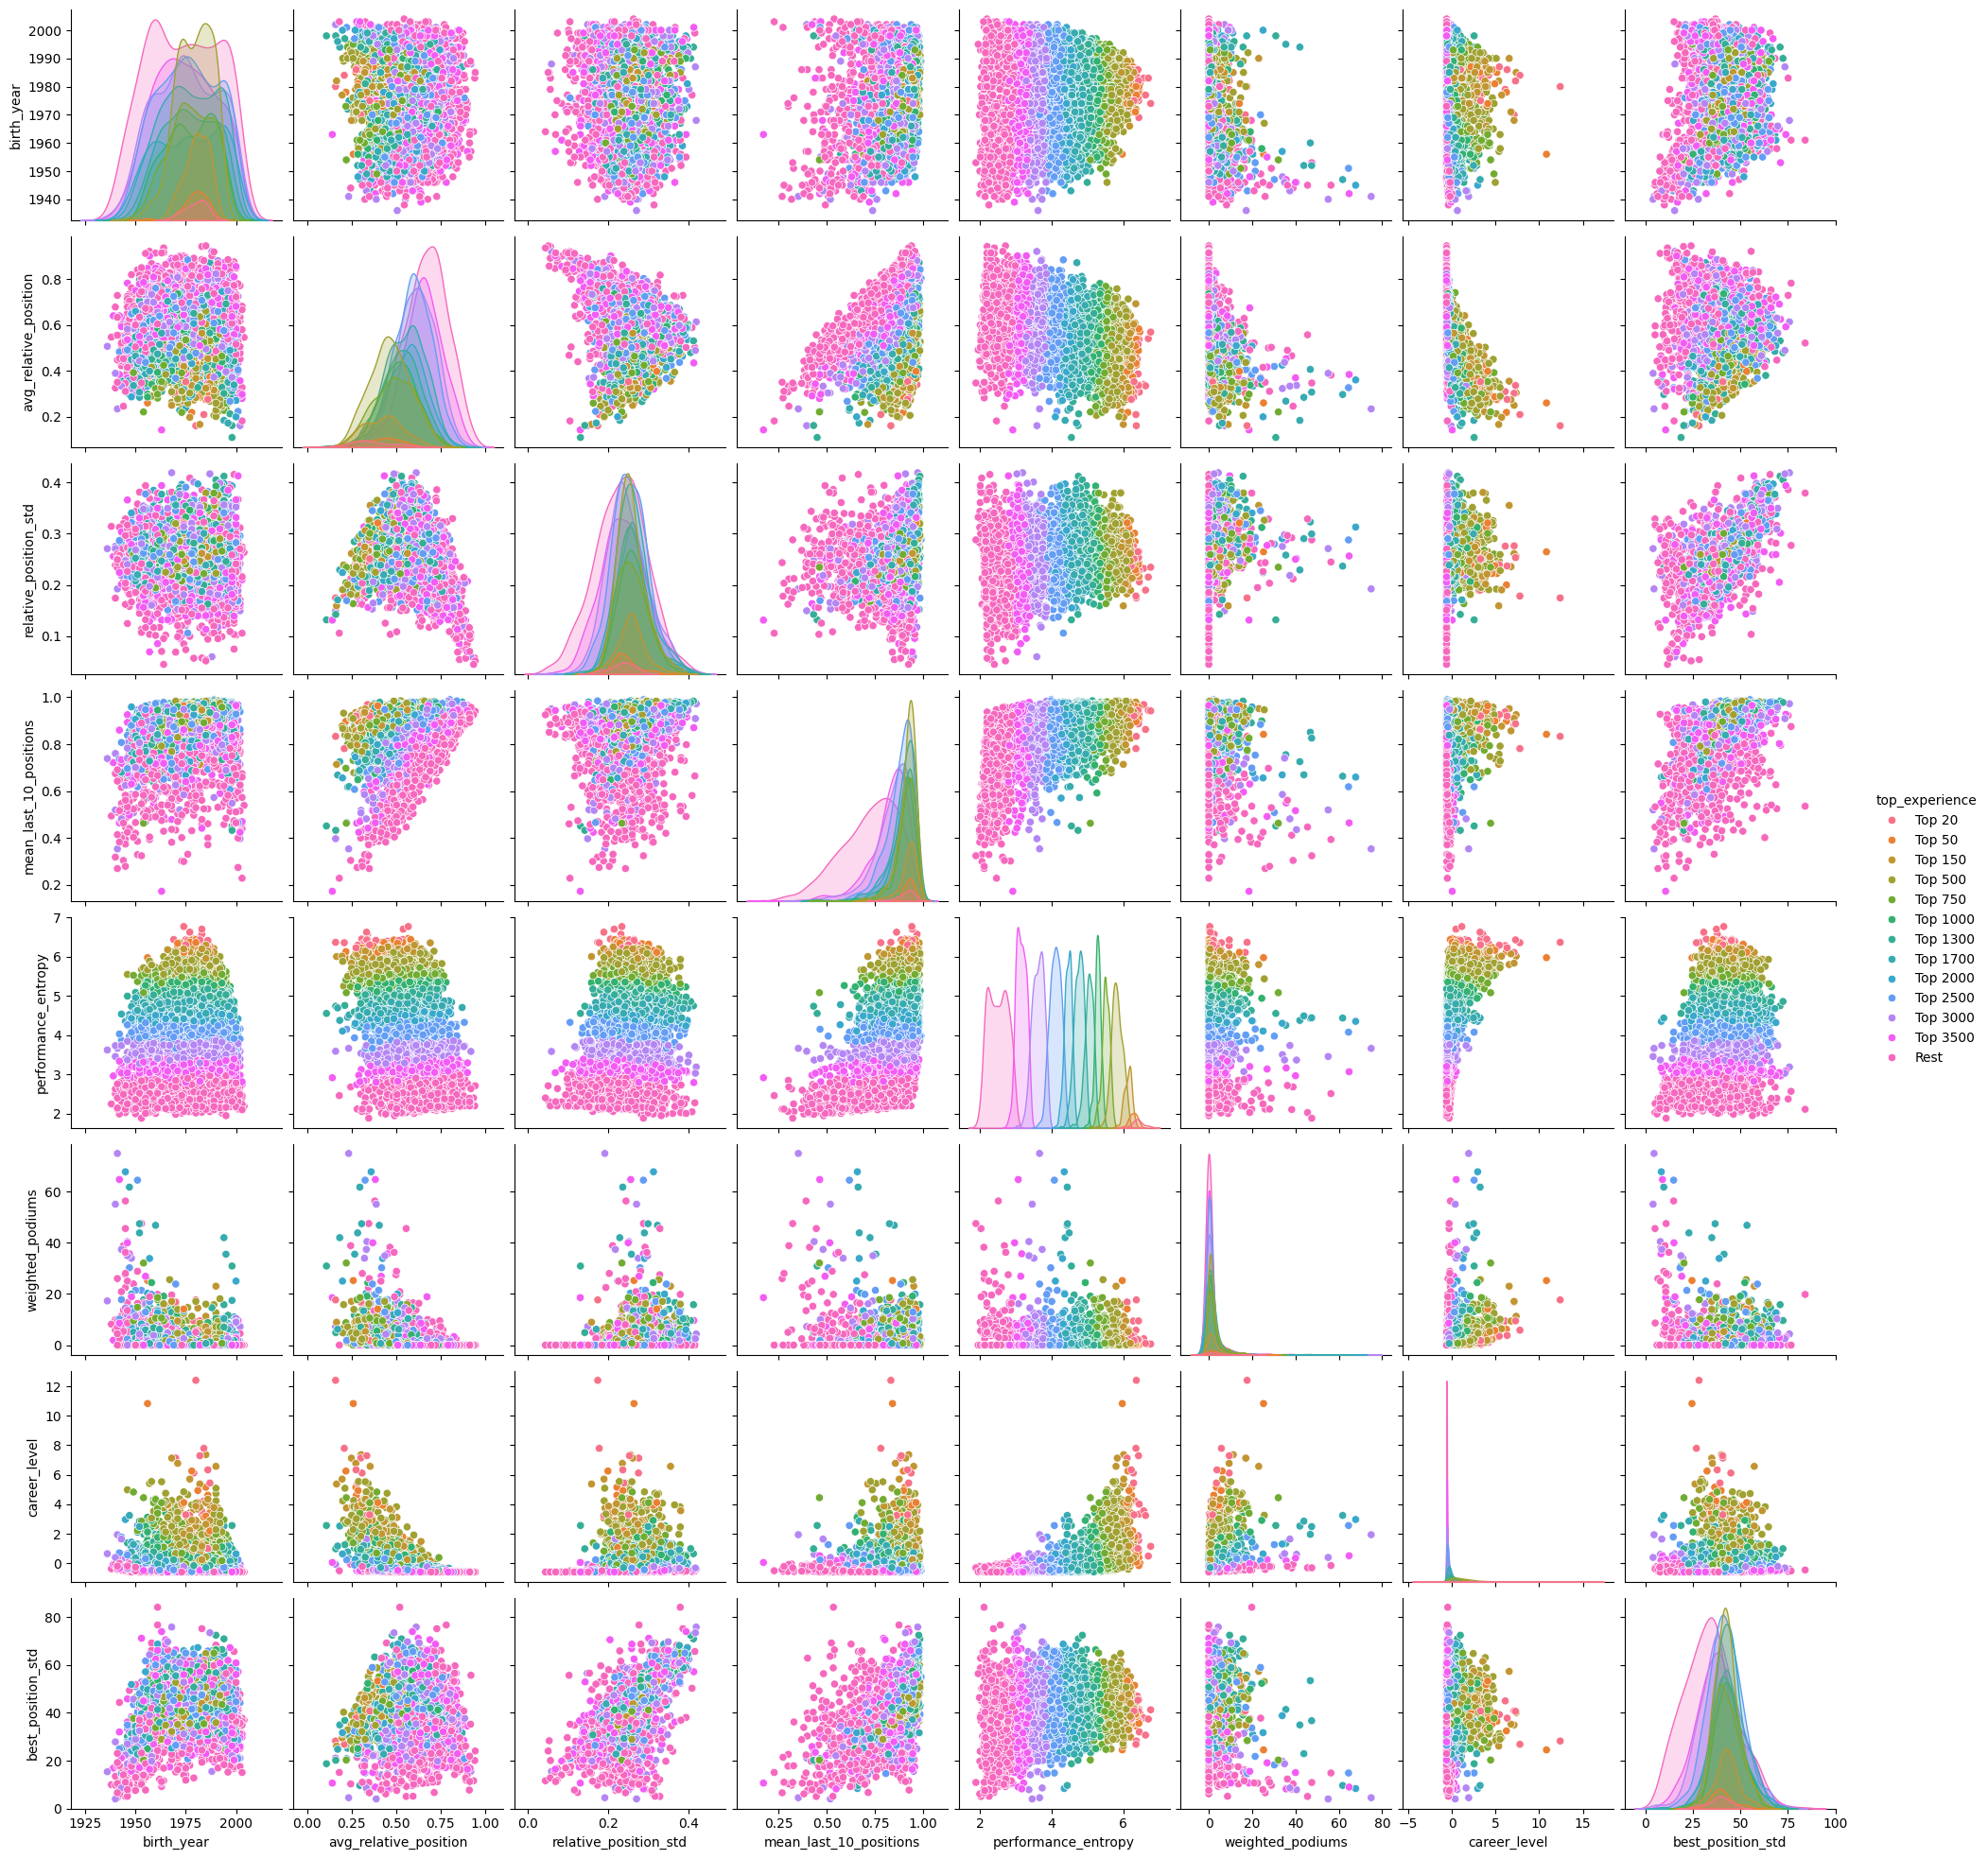

In [80]:
sns.pairplot(cyclists_df.drop(columns = ["cyclist_win", "cyclist_experience", "avg_position", "best_position",
                                         "avg_performance_vs_startlist", "min_relative_position", 
                                         "cyclist_win_ratio"]), hue='top_experience')
plt.show()

We filter out only first nationality as they are the most represented to do a scatter plot basing on nationality

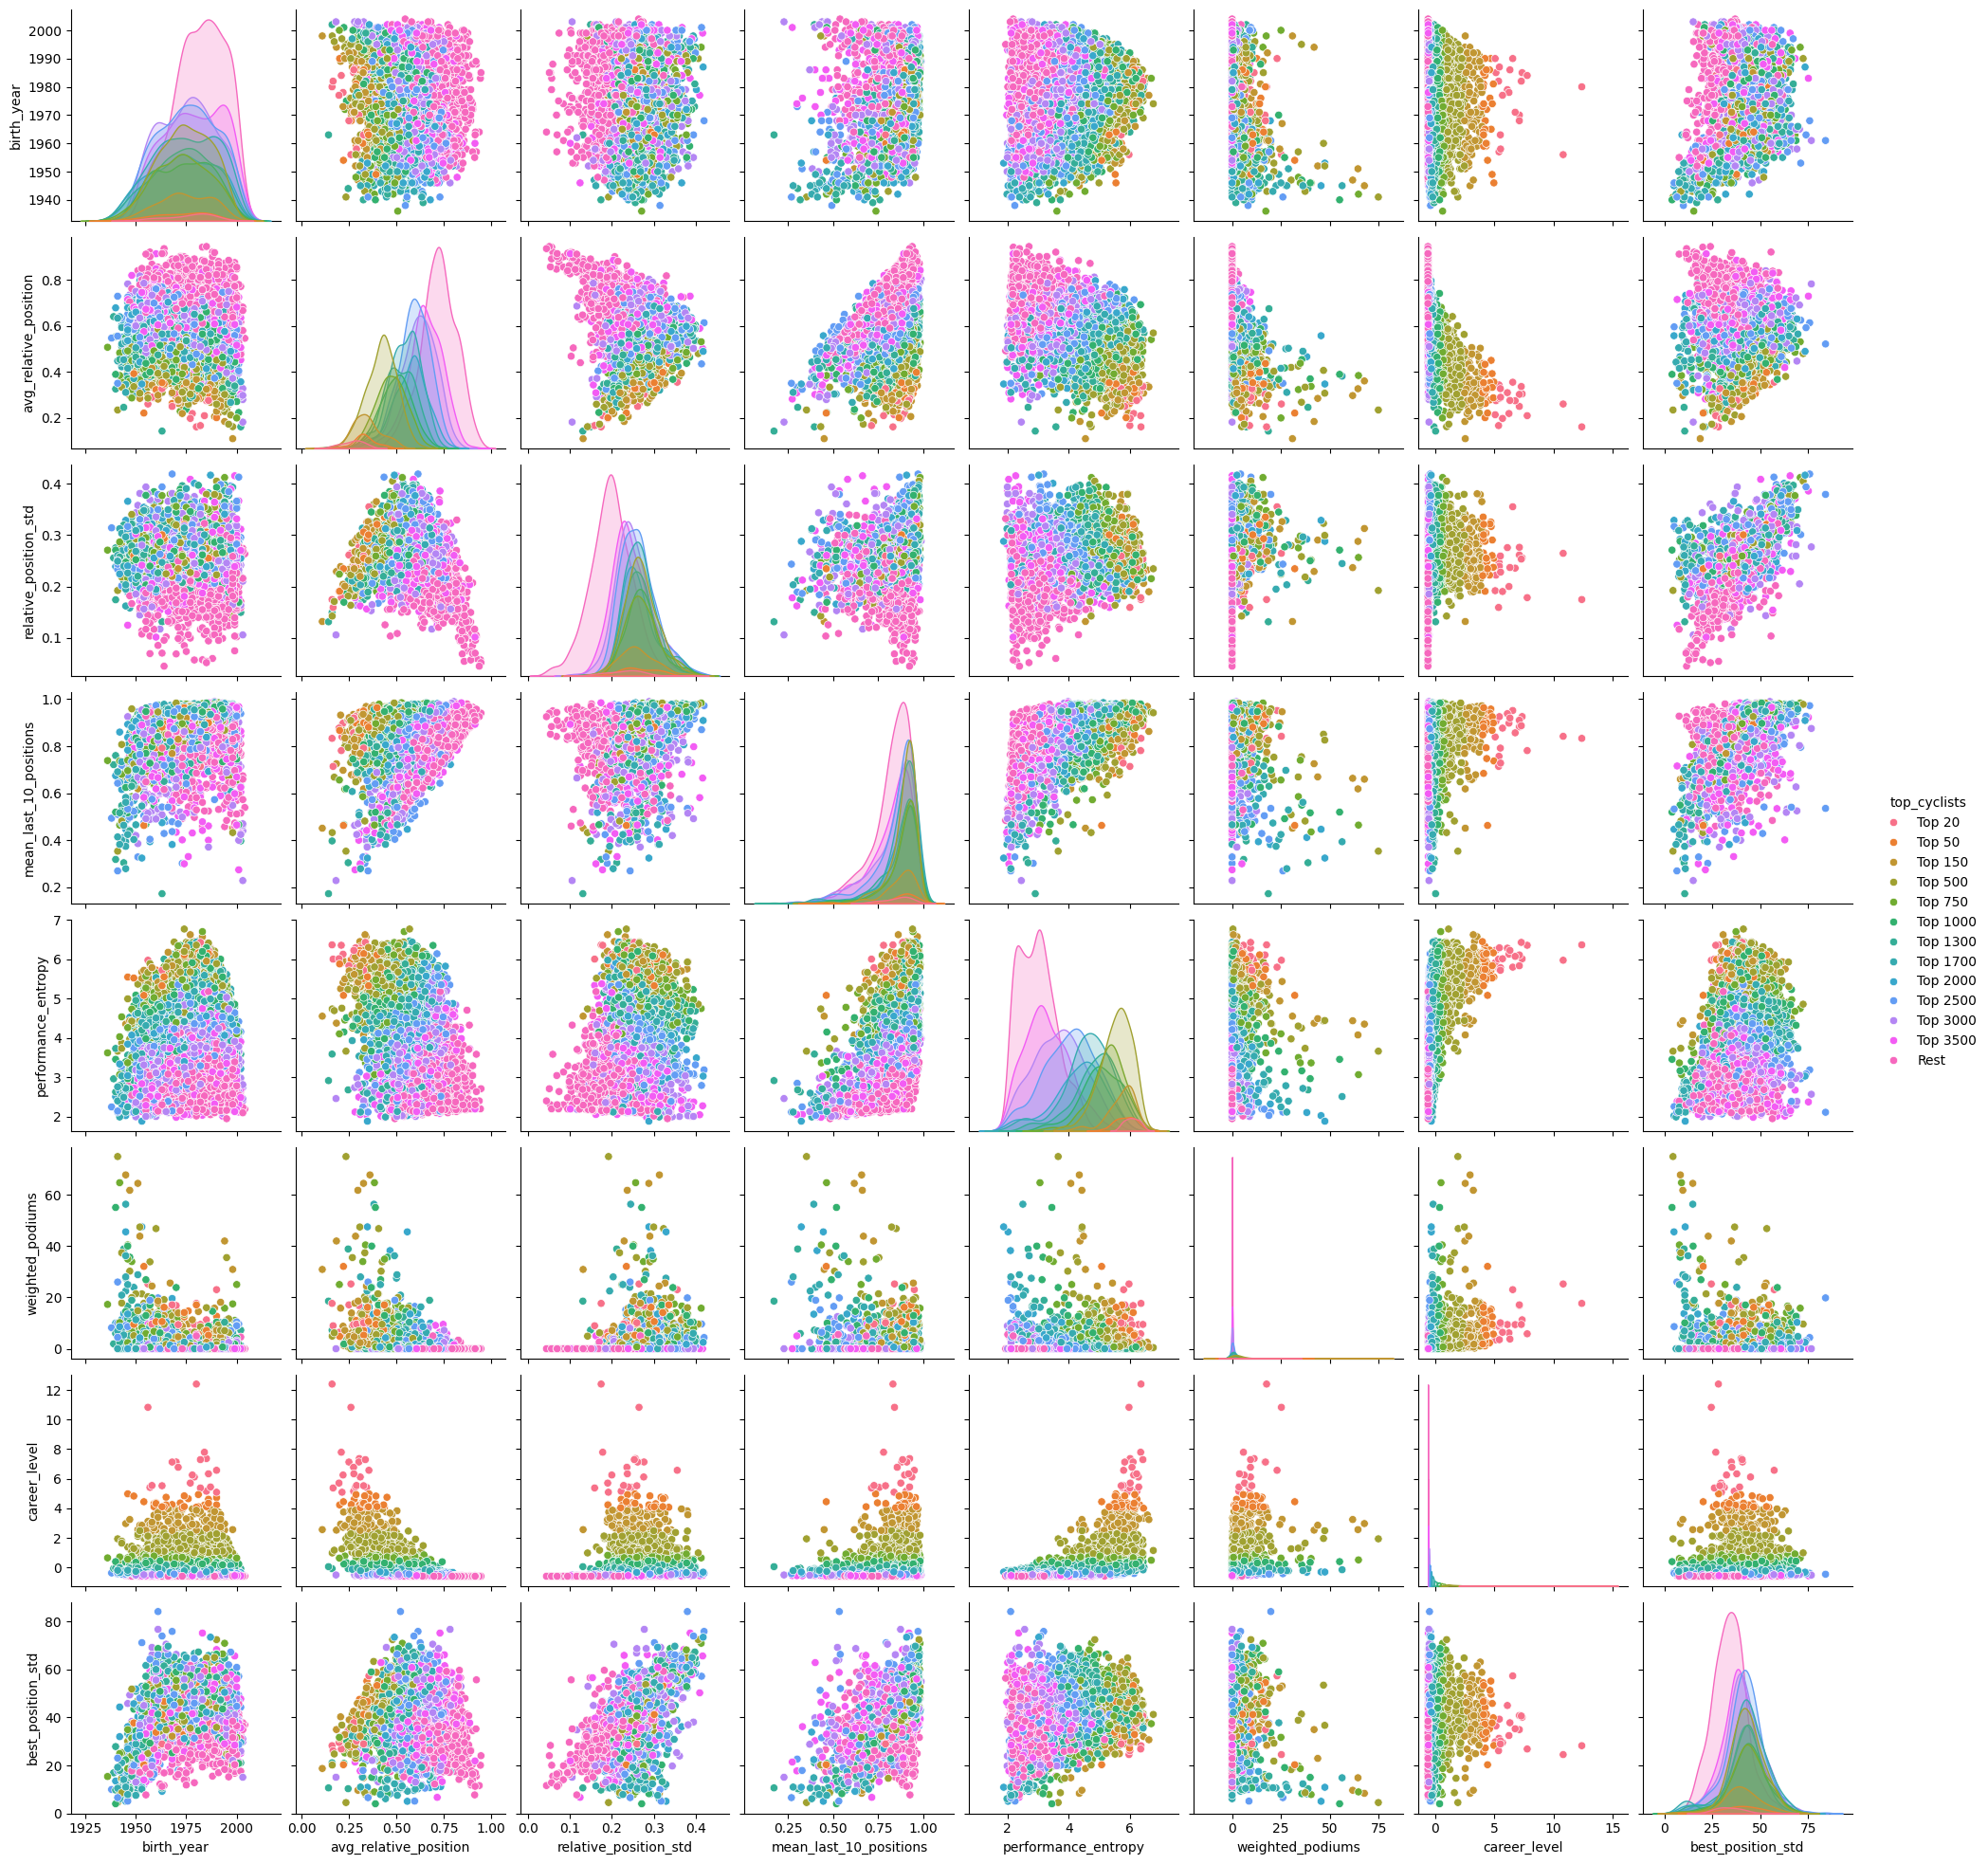

In [81]:
sns.pairplot(cyclists_df.drop(columns= ["cyclist_win", "cyclist_experience", "avg_position", "best_position", 
                  "avg_performance_vs_startlist", "min_relative_position", "cyclist_win_ratio"]), hue='top_cyclists')
plt.show()

## Correlation Analysis

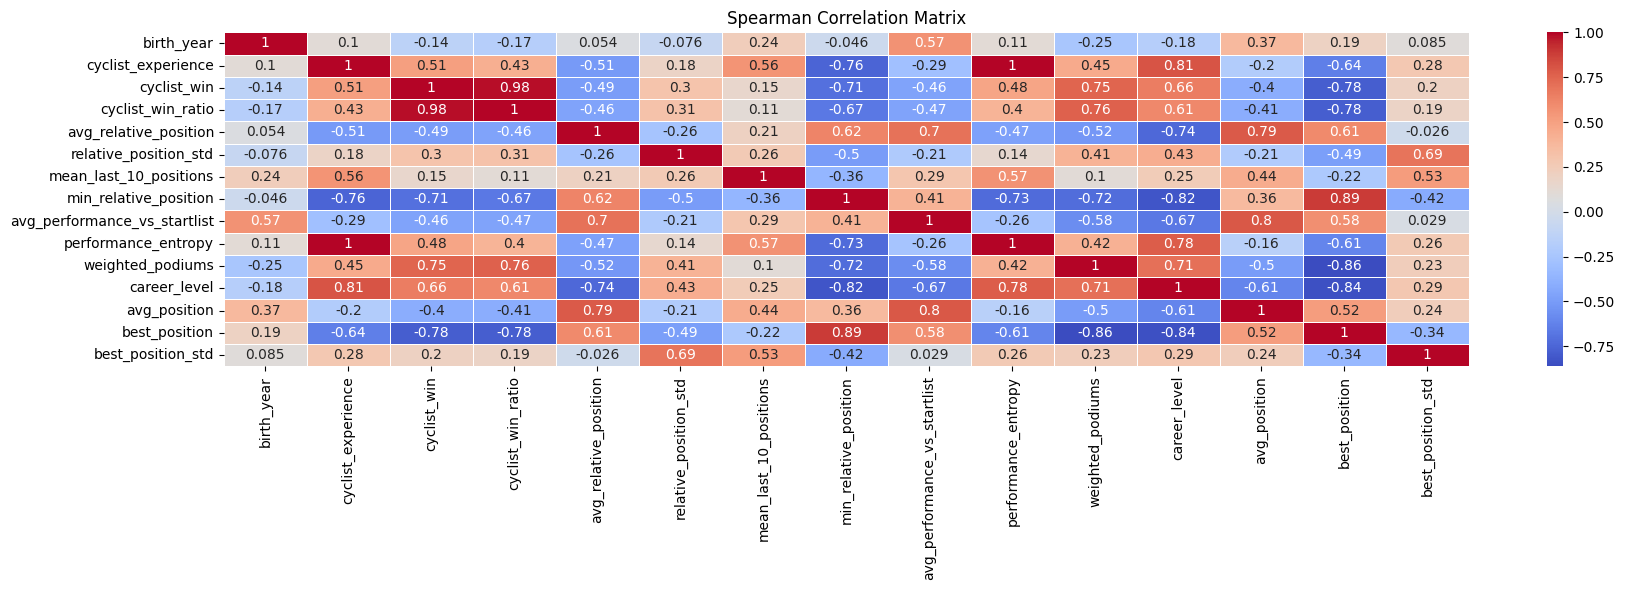

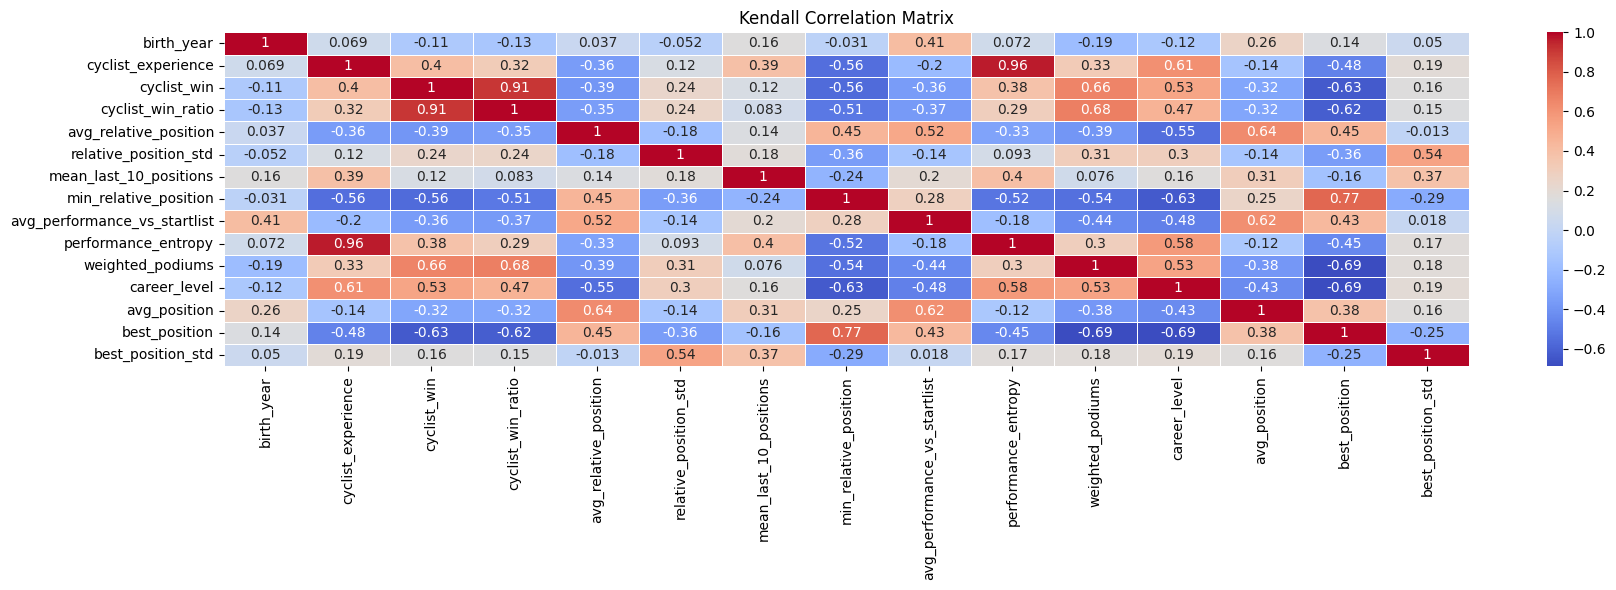

'cyclists_corr = correlations(normalized_cyclist, ["pearson"])\nplot_correlations(cyclists_corr)'

In [82]:
from utils import center_and_scale, correlations, plot_correlations

normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_df)
cyclists_corr = correlations(normalized_cyclist, ["spearman"])
plot_correlations(cyclists_corr)
cyclists_corr = correlations(normalized_cyclist, ["kendall"])
plot_correlations(cyclists_corr)
"""cyclists_corr = correlations(normalized_cyclist, ["pearson"])
plot_correlations(cyclists_corr)"""



For clustering analysis we will ocnsider only non highly correlated features

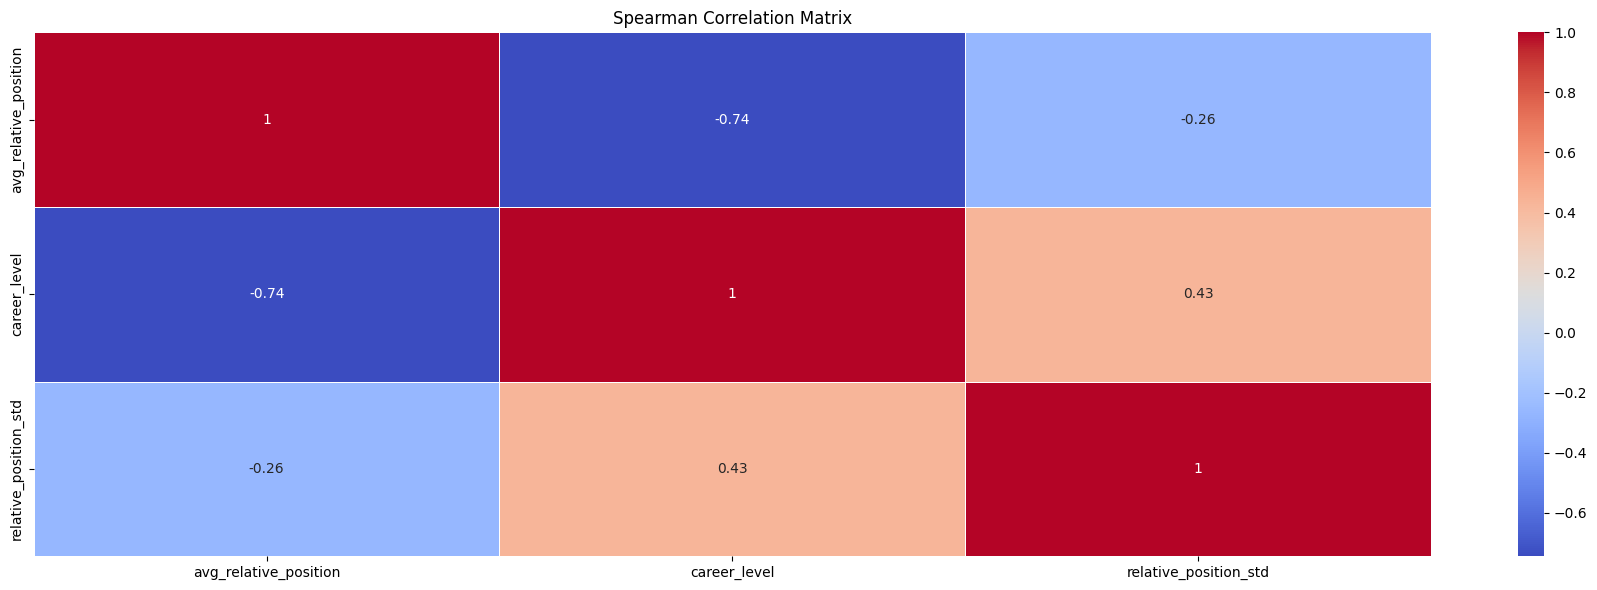

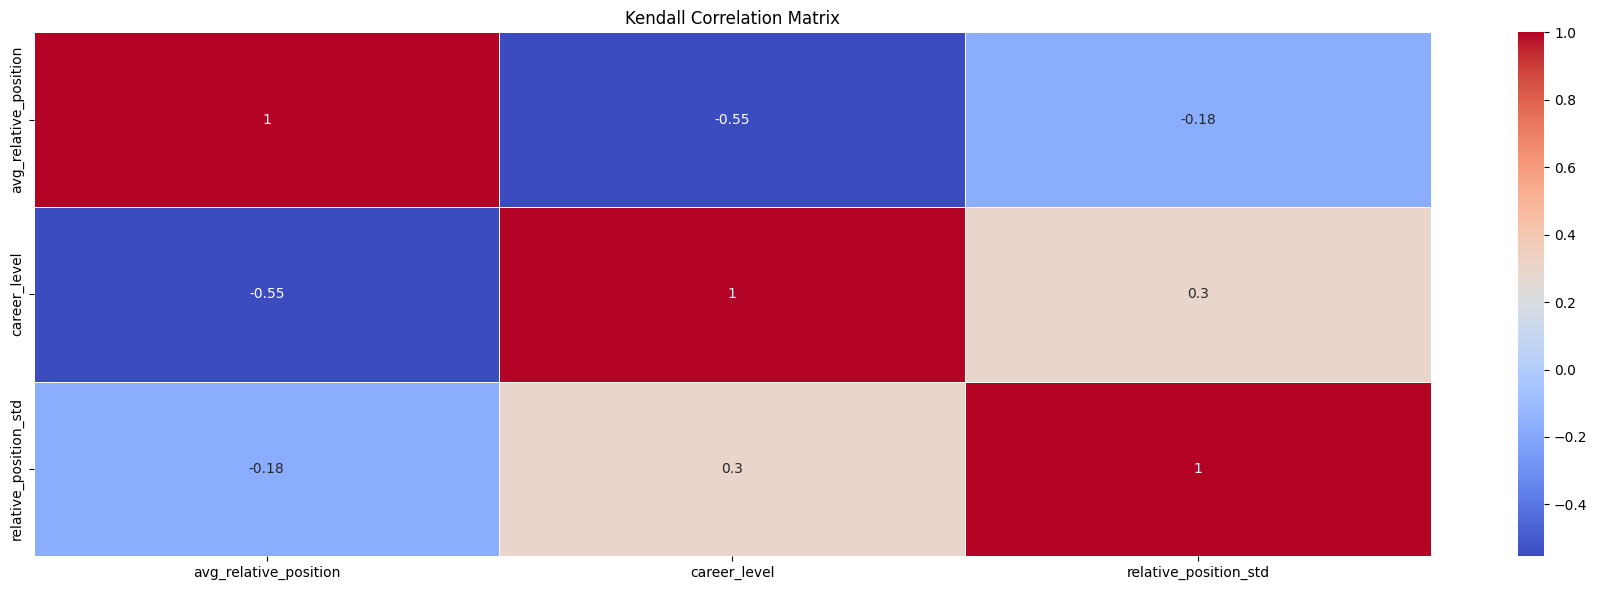

['avg_relative_position', 'career_level', 'performance_entropy']

In [83]:
from utils import center_and_scale, correlations, plot_correlations

columns_to_keep = ["avg_relative_position", "career_level", "relative_position_std"] 

normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_df[columns_to_keep])
cyclists_corr = correlations(normalized_cyclist, ["spearman"])
plot_correlations(cyclists_corr)
normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_df[columns_to_keep])
cyclists_corr = correlations(normalized_cyclist, ["kendall"])
plot_correlations(cyclists_corr)

["avg_relative_position", "career_level", "performance_entropy"] 

In [84]:
cyclists_df.to_csv('dataset/cyclists_clustering.csv', index=False)